## Import modules

In [1]:
import os
import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import math
import tensorlayer as tl

slim = tf.contrib.slim
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(tf.__version__)

NUM_CLASSES = 10
NUM_PARALLEL_CALLS = 2 # number of cpu cores
BATCH_SIZE = 7
REPEAT_DATASET = 1

1.12.0


## Dataset setup

In [2]:
import mnist_reader
train_images, train_labels = mnist_reader.load_mnist('datasets/mnist', kind='train')
test_images, test_labels = mnist_reader.load_mnist('datasets/mnist', kind='t10k')

In [3]:
print("\n-------------------------------")
print("train_images shape: " + str(train_images.shape))
print("train_labels shape: " + str(train_labels.shape))
print("valid_images shape: " + str(test_images.shape))
print("valid_labels shape: " + str(test_labels.shape))
print("-------------------------------\n")


-------------------------------
train_images shape: (60000, 28, 28, 1)
train_labels shape: (60000,)
valid_images shape: (10000, 28, 28, 1)
valid_labels shape: (10000,)
-------------------------------



In [4]:
# create the training datasets
dx_train = tf.data.Dataset.from_tensor_slices(train_images)

# apply a one-hot transformation to each label for use in the neural network
dy_train = tf.data.Dataset.from_tensor_slices(train_labels)
dy_train = dy_train.map(lambda z: tf.one_hot(z, 10), num_parallel_calls=NUM_PARALLEL_CALLS)
dy_train = dy_train.repeat()

# zip the x and y training data together and shuffle, batch etc.
train_dataset = tf.data.Dataset.zip((dx_train, dy_train)).shuffle(500)
train_dataset = train_dataset.repeat(REPEAT_DATASET)
train_dataset = train_dataset.batch(BATCH_SIZE)

# do the same for validation set
dx_valid = tf.data.Dataset.from_tensor_slices(test_images)
dy_valid = tf.data.Dataset.from_tensor_slices(test_labels)
dy_valid = dy_valid.map(lambda z: tf.one_hot(z, 10), num_parallel_calls=NUM_PARALLEL_CALLS)
dy_valid = dy_valid.repeat()

test_dataset = tf.data.Dataset.zip((dx_valid, dy_valid)).shuffle(500)
test_dataset = test_dataset.repeat(REPEAT_DATASET)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [5]:
# create general iterator
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                            train_dataset.output_shapes)
next_batch = iterator.get_next()

# make datasets that we can initialize separately, but using the same structure via the common iterator
training_init_op = iterator.make_initializer(train_dataset)
test_init_op = iterator.make_initializer(test_dataset)

## Model setup

In [6]:
with tf.name_scope('input'):
    input_images = tf.placeholder(tf.float32, shape=(None,28,28,1), name='input_images')
    labels = tf.placeholder(tf.int64, shape=(None, NUM_CLASSES), name='labels')
    
global_step = tf.Variable(0, trainable=False, name='global_step')


def parametric_relu(_x):
  alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                       initializer=tf.constant_initializer(0.0),
                        dtype=tf.float32)
  pos = tf.nn.relu(_x)
  neg = alphas * (_x - abs(_x)) * 0.5

  return pos + neg


# def inference(input_images):
#     with slim.arg_scope([slim.conv2d], kernel_size=3, padding='SAME'):
#         with slim.arg_scope([slim.max_pool2d], kernel_size=2):
            
#             x = slim.conv2d(input_images, num_outputs=32, scope='conv1_1')
#             x = slim.conv2d(x, num_outputs=32, scope='conv1_2')
#             x = slim.max_pool2d(x, scope='pool1')
     
#             x = slim.conv2d(x, num_outputs=64, scope='conv2_1')
#             x = slim.conv2d(x, num_outputs=64, scope='conv2_2')
#             x = slim.max_pool2d(x, scope='pool2')
            
#             x = slim.conv2d(x, num_outputs=128, scope='conv3_1')
#             x = slim.conv2d(x, num_outputs=128, scope='conv3_2')
#             x = slim.max_pool2d(x, scope='pool3')
            
#             x = slim.flatten(x, scope='flatten')
            
#             features3d = slim.fully_connected(x, num_outputs=3, activation_fn=None, scope='fc0')
#             features2d = slim.fully_connected(features3d, num_outputs=2, activation_fn=None, scope='fc1')

#             x = parametric_relu(features3d)
#             x = slim.fully_connected(x, num_outputs=NUM_CLASSES, activation_fn=None, scope='fc2')
    
#     return x, features2d, features3d

def inference(input_images):
    with slim.arg_scope([slim.conv2d], kernel_size=3, padding='SAME'):
        with slim.arg_scope([slim.max_pool2d], kernel_size=2):
            
            with tf.name_scope('conv_scope') as scope:
                x = slim.conv2d(input_images, num_outputs=32, scope='conv1_1')
                x = slim.conv2d(x, num_outputs=32, scope='conv1_2')
            x = slim.max_pool2d(x, scope='pool1')
     
            with tf.name_scope('conv_scope') as scope:
                x = slim.conv2d(x, num_outputs=64, scope='conv2_1')
                x = slim.conv2d(x, num_outputs=64, scope='conv2_2')
            x = slim.max_pool2d(x, scope='pool2')
            
            with tf.name_scope('conv_scope') as scope:
                x = slim.conv2d(x, num_outputs=128, scope='conv3_1')
                x = slim.conv2d(x, num_outputs=128, scope='conv3_2')
            x = slim.max_pool2d(x, scope='pool3')
            
            x = slim.flatten(x, scope='flatten')
            
            features3d = slim.fully_connected(x, num_outputs=3, activation_fn=None, scope='fc0')
#             features2d = slim.fully_connected(features3d, num_outputs=2, activation_fn=None, scope='fc1')

            x = parametric_relu(features3d)
            
            with tf.name_scope('fc_scope') as scope:
                x = slim.fully_connected(x, num_outputs=NUM_CLASSES, activation_fn=None, scope='fc2')
    
    return x, features3d

In [7]:
def arcface_loss(embedding, labels, out_num, w_init=None, s=64., m=0.5):
    '''
    :param embedding: the input embedding vectors
    :param labels:  the input labels, the shape should be eg: (batch_size, 1)
    :param s: scalar value default is 64
    :param out_num: output class num
    :param m: the margin value, default is 0.5
    :return: the final cacualted output, this output is send into the tf.nn.softmax directly
    '''
    cos_m = math.cos(m)
    sin_m = math.sin(m)
    mm = sin_m * m  # issue 1
    threshold = math.cos(math.pi - m)
    with tf.variable_scope('arcface_loss'):
        # inputs and weights norm
        embedding_norm = tf.norm(embedding, axis=1, keep_dims=True)
        embedding = tf.div(embedding, embedding_norm, name='norm_embedding')
        weights = tf.get_variable(name='embedding_weights', shape=(embedding.get_shape().as_list()[-1], out_num),
                                  initializer=w_init, dtype=tf.float32)
        weights_norm = tf.norm(weights, axis=0, keep_dims=True)
        weights = tf.div(weights, weights_norm, name='norm_weights')
        # cos(theta+m)
        cos_t = tf.matmul(embedding, weights, name='cos_t')
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = s * tf.subtract(tf.multiply(cos_t, cos_m), tf.multiply(sin_t, sin_m), name='cos_mt')

        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_t - threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)

        keep_val = s*(cos_t - mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)

        mask = tf.one_hot(labels, depth=out_num, name='one_hot_mask')
        # mask = tf.squeeze(mask, 1)
        inv_mask = tf.subtract(1., mask, name='inverse_mask')

        s_cos_t = tf.multiply(s, cos_t, name='scalar_cos_t')

        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_loss_output')
    return output


In [8]:
def loss(logits, features, labels, wd_loss):
    with tf.name_scope('loss'):
#         with tf.name_scope('center_loss'):
#             label_non_one_hot = tf.argmax(labels, 1)
#             center_loss, centers, centers_update_op = get_center_loss(features, label_non_one_hot, CENTER_LOSS_ALPHA, NUM_CLASSES)        
#         with tf.name_scope('softmax_loss'):
#             softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))

#         with tf.name_scope('total_loss'):
#             softmax_loss_index = tf.cast(softmax_loss, tf.float32)
#             total_loss = softmax_loss_index + ratio * center_loss            

            
            
        with tf.name_scope('arcface_loss'):
            label_non_one_hot = tf.argmax(labels, 1)
            w_init_method = tf.contrib.layers.xavier_initializer(uniform=False)
            
            logit = arcface_loss(embedding=logits, labels=label_non_one_hot, w_init=w_init_method, out_num=28)
            inference_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logit, labels=label_non_one_hot))
            
            total_loss = inference_loss + wd_loss 

    with tf.name_scope('loss/'):
#         tf.summary.scalar('SoftmaxLoss', softmax_loss)
#         tf.summary.scalar('CenterLoss', center_loss)
#         tf.summary.scalar('TotalLoss', total_loss)
        tf.summary.scalar('ArcfaceLoss', total_loss)

    return total_loss

def accuracy(labels):
    with tf.name_scope('acc'):
        prediction = tf.argmax(logits, 1)        
        equality = tf.equal(prediction, tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    return accuracy

In [9]:
logits, features3d = inference(input_images)

# define weight decay losses
weight_decay = 5e-4
wd_loss = 0
for W in slim.get_variables(scope='conv_scope'):
    wd_loss += tf.contrib.layers.l2_regularizer(weight_decay)(W)
for W in slim.get_variables(scope='fc_scope'):
    wd_loss += tf.contrib.layers.l2_regularizer(weight_decay)(W)
for weights in tl.layers.get_variables_with_name('embedding_weights', True, True):
    wd_loss += tf.contrib.layers.l2_regularizer(weight_decay)(weights)
for alphas in tl.layers.get_variables_with_name('alpha', True, True):
    wd_loss += tf.contrib.layers.l2_regularizer(weight_decay)(alphas)


loss = loss(logits, features3d, labels, wd_loss)
accuracy = accuracy(labels)

[TL]   [*] geting variables with embedding_weights
[TL]   [*] geting variables with alpha
[TL]   got   0: alpha:0           (3,)
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss, global_step=global_step)

In [11]:
# prediction = tf.argmax(logits, 1)
init_op = tf.global_variables_initializer()
summary_op = tf.summary.merge_all()

## Training the model

In [12]:
mean_data = np.mean(train_images, axis=0)

In [13]:
from tensorflow.python import debug as tf_debug

# run the training
epochs = 8000
sess = tf.Session()
# sess = tf_debug.TensorBoardDebugWrapperSession(sess, "Eugenes-MBP:7000")
# Start Tensorflow from this file 'tensorboard --logdir=/tmp/mnist_log --debugger_port 7000'

sess.run(tf.global_variables_initializer())
sess.run(init_op)
sess.run(training_init_op)

writer = tf.summary.FileWriter('/tmp/mnist_log', sess.graph)
# Start Tensorflow from this file 'tensorboard --logdir=/tmp/mnist_log'

for i in range(epochs):

    img_batch, label_batch = sess.run(next_batch)
    l, _, acc, summary_str = sess.run([loss, optimizer, accuracy, summary_op],
                                         feed_dict={input_images: img_batch-mean_data,labels: label_batch})

    writer.add_summary(summary_str, global_step=epochs)

    if i % 50 == 0:
        print("Epoch: {}, loss: {:.3f}, training accuracy: {:.2f}%".format(i, l, acc * 100)) 



# now setup the validation run
test_iters = 100
# re-initialize the iterator, but this time with validation data
sess.run(test_init_op)
avg_acc = 0
for i in range(test_iters):
    img_batch, label_batch = sess.run(next_batch)
    acc = sess.run([accuracy], feed_dict={input_images: img_batch-mean_data,labels: label_batch})
    avg_acc += acc[0]
print("Average validation set accuracy over {} iterations is {:.2f}%".format(test_iters, (avg_acc / test_iters) * 100))


Epoch: 0, loss: 74.051, training accuracy: 14.29%
Epoch: 50, loss: 50.148, training accuracy: 0.00%
Epoch: 100, loss: 33.880, training accuracy: 0.00%
Epoch: 150, loss: 32.884, training accuracy: 0.00%
Epoch: 200, loss: 31.709, training accuracy: 0.00%
Epoch: 250, loss: 16.589, training accuracy: 0.00%
Epoch: 300, loss: 31.861, training accuracy: 28.57%
Epoch: 350, loss: 18.158, training accuracy: 0.00%
Epoch: 400, loss: 27.177, training accuracy: 0.00%
Epoch: 450, loss: 22.390, training accuracy: 14.29%
Epoch: 500, loss: 28.380, training accuracy: 0.00%
Epoch: 550, loss: 24.731, training accuracy: 0.00%
Epoch: 600, loss: 12.165, training accuracy: 0.00%
Epoch: 650, loss: 17.941, training accuracy: 14.29%
Epoch: 700, loss: 8.376, training accuracy: 0.00%
Epoch: 750, loss: 25.721, training accuracy: 14.29%
Epoch: 800, loss: 10.560, training accuracy: 14.29%
Epoch: 850, loss: 18.763, training accuracy: 0.00%
Epoch: 900, loss: 7.120, training accuracy: 0.00%
Epoch: 950, loss: 6.242, train

## Visualize train_data

In [14]:
# feat = sess.run(features2d, feed_dict={input_images:train_images[:20000]-mean_data})

# %matplotlib inline
# import matplotlib.pyplot as plt

# labels = train_labels[:20000]

# f = plt.figure(figsize=(16,9))
# c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
#      '#ff00ff', '#990000', '#999900', '#009900', '#009999']
# for i in range(10):
#     plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
# plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# plt.grid()
# plt.show()

### Visualize test_data

In [15]:
# feat = sess.run(features2d, feed_dict={input_images:test_images[:20000]-mean_data})

# %matplotlib inline
# import matplotlib.pyplot as plt

# labels = test_labels[:20000]

# f = plt.figure(figsize=(16,9))
# c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', 
#      '#ff00ff', '#990000', '#999900', '#009900', '#009999']
# for i in range(10):
#     plt.plot(feat[labels==i,0].flatten(), feat[labels==i,1].flatten(), '.', c=c[i])
# plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
# plt.grid()
# plt.show()

### Visualize train_data 3D

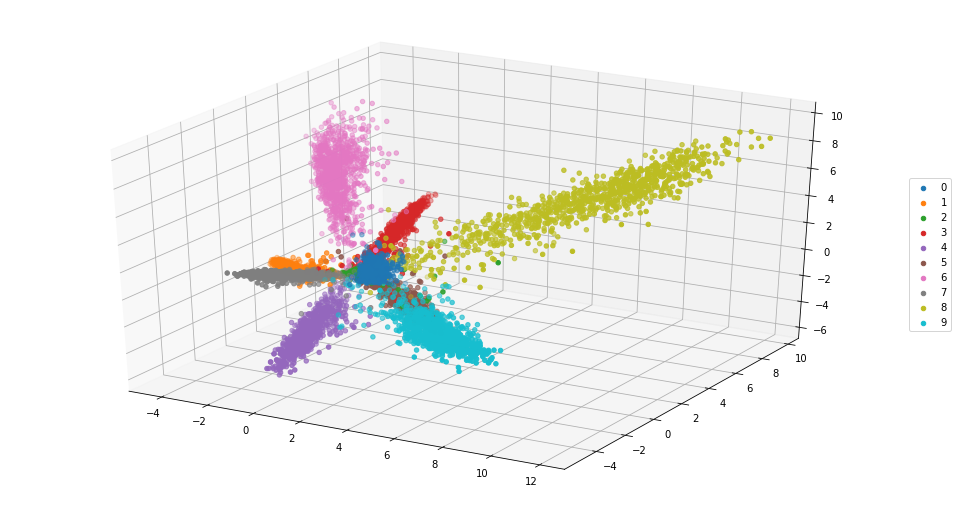

In [16]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

feat = sess.run(features3d, feed_dict={input_images:train_images[:10000]-mean_data})
labels = train_labels[:10000]

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat[labels==i,2].flatten()
    ydata = feat[labels==i,0].flatten()
    zdata = feat[labels==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Visualize test_data 3D

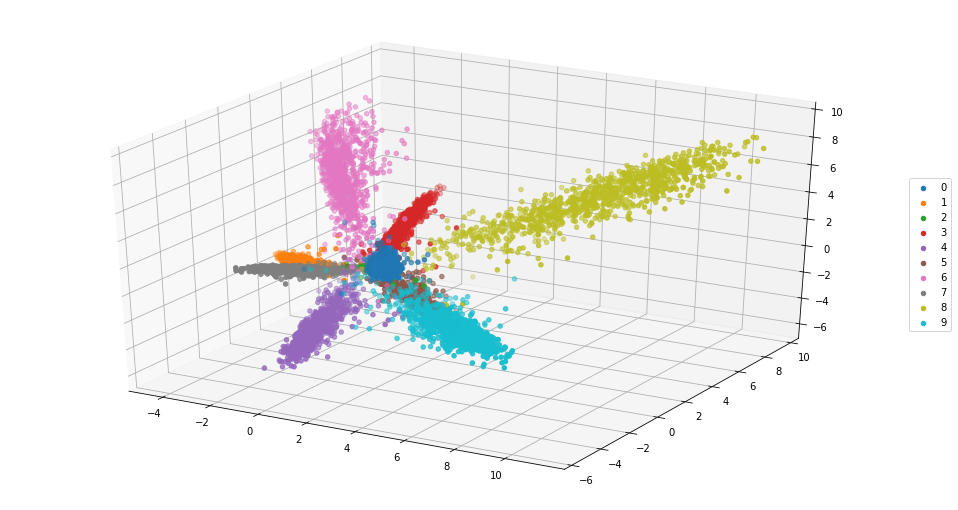

In [17]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

feat = sess.run(features3d, feed_dict={input_images:test_images[:10000]-mean_data})
labels = test_labels[:10000]

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = feat[labels==i,2].flatten()
    ydata = feat[labels==i,0].flatten()
    zdata = feat[labels==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [18]:
# sess.close()

prediction: [array([[-1.0314512 , -0.6937977 ,  3.4502575 ,  1.9222645 ,  0.78358465,
        -3.5865479 ,  2.1717954 , -1.7979114 , -2.1079597 ,  3.0879908 ]],
      dtype=float32)]


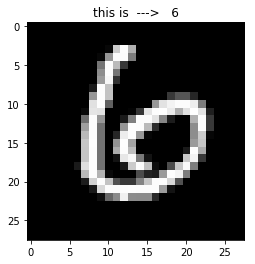

In [25]:
ind = 11
digit = test_images[ind].reshape(28,28)
plt.title('this is  --->   ' + str(test_labels[ind]))
plt.imshow(digit, cmap='gray')

tf.reset_default_graph()
feed_image = test_images[ind].reshape(1,28,28,1)
prediction = sess.run([logits],feed_dict={input_images: feed_image})
print("prediction: " + str(prediction))

In [20]:
# sess.close()